In [2]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Set paths to test images and model

Take the ecommerce model as an example.

In [3]:
## Test dataset directory. 
test_data_dir = "test_img"
## Model path.
model_path = "model/image_model"

tf.reset_default_graph()

## Define supportive functions

In [4]:
def read_test_data(data_dir):
    """
    This function read in the testing dataset.
    INPUT: data_dir -- Test dataset directory.
    OUTPUT: fpaths  -- a list of paths of the files in the dataset.
            fnames  -- a list of file names.
            datas   -- training data.
            labels  -- corresponding labes for the training data.
    """
    datas = []
    fpaths = []
    fnames = []
    for fname in os.listdir(data_dir):
        fpath = os.path.join(data_dir, fname)
        fpaths.append(fpath)
        fnames.append(fname)
        image = Image.open(fpath)
        image = image.resize((256,256),Image.BILINEAR) 
        image = image.convert("RGB")
        data = np.array(image) / 255.0
        datas.append(data)

    datas = np.array(datas)

    print("Shape of testing datas: {}".format(datas.shape))
    return fpaths, fnames, datas

def compute_accuracy(v_xs, v_ys):
    """
    This function computes the accuracy of the model.
    INPUT: v_xs -- datas.
           v_ys -- corresponding labels.
    OUTPUT: result -- test accuracy.
    """
    
    global predicted_labels
    global test_paths, test_label
    global num_test_examples

    y_pre = sess.run(predicted_labels, feed_dict={datas_placeholder: v_xs, dropout_placeholdr: 1}) ## dropout rate is 1 when testing
    correct_prediction = tf.equal(y_pre, v_ys)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={datas_placeholder: v_xs, labels_placeholder: v_ys, dropout_placeholdr: 1})
     
    return result

test_paths, test_names, test_data = read_test_data(test_data_dir)

num_test_examples = test_data.shape[0]  ## Number of testing examples

Shape of testing datas: (10, 256, 256, 3)


## Defien the network

In [5]:
## Define placeholders for inputs and labels.
datas_placeholder = tf.placeholder(tf.float32, [None, 256, 256, 3])
labels_placeholder = tf.placeholder(tf.int32, [None])
## Define a placeholder for dropout.
dropout_placeholdr = tf.placeholder(tf.float32)

## Add convolutional layers and max pooling layers.
conv0 = tf.layers.conv2d(datas_placeholder, 32, 5, activation=tf.nn.relu)
pool0 = tf.layers.max_pooling2d(conv0, [2,2], [2, 2])
conv1 = tf.layers.conv2d(pool0, 64, 5, activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(conv1, [2,2], [2, 2])
conv2 = tf.layers.conv2d(pool1, 128, 5, activation=tf.nn.relu) 
pool2 = tf.layers.max_pooling2d(conv2, [2,2], [2, 2])
conv3 = tf.layers.conv2d(pool2, 256, 3, activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(conv3, [2,2], [2, 2])
conv4 = tf.layers.conv2d(pool3, 512, 3, activation=tf.nn.relu)
pool4 = tf.layers.max_pooling2d(conv4, [2,2],[2,2])
conv5 = tf.layers.conv2d(pool4, 1024, 3, activation=tf.nn.relu)
pool5 = tf.layers.max_pooling2d(conv5, [2,2],[2,2])

## Flatten layer.
flatten = tf.layers.flatten(pool5)

## Two fully connected layers.
fc_1 = tf.layers.dense(flatten, 2048, activation = tf.nn.relu)
fc_2 = tf.layers.dense(fc_1, 1024, activation = tf.nn.relu)

## Dropout layer.
dropout_fc = tf.nn.dropout(fc_2, dropout_placeholdr)

## Output layer.
logits = tf.layers.dense(dropout_fc, 2)

predicted_labels = tf.arg_max(logits, 1)
losses = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(labels_placeholder, 2),
    logits=logits
)
mean_loss = tf.reduce_mean(losses)
## AdamOptimizer with learning rate of 0.0001.
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(mean_loss)

Instructions for updating:
Use `argmax` instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Run the model

In [6]:
# Save the model
saver = tf.train.Saver()

with tf.Session() as sess:
    # Load the parameters from model path.
    saver.restore(sess, model_path)
    print("Reload the model from {}".format(model_path))
    
    ## Classes names.
    label_name_dict = {
        0: "ecommerce",
        1: "other"
    }
        
    test_feed_dict = {
        datas_placeholder: test_data,
        dropout_placeholdr: 1
    }
        
    ## Run the model
    y_pre = sess.run(predicted_labels, feed_dict=test_feed_dict)
    predicted_labels = []
    # Output file names and the predicted label
    for fpath, fname, predicted_label in zip(test_paths, test_names, y_pre):
        predicted_label_name = label_name_dict[predicted_label]
        predicted_labels.append(predicted_label_name)
        print("{}\t=> {}".format(fname, predicted_label_name))

INFO:tensorflow:Restoring parameters from model/image_model
Reload the model from model/image_model
4003612.png	=> other
4003743.jpg	=> other
4005031.png	=> other
4006784.png	=> other
4006936.png	=> other
4011004.jpg	=> ecommerce
4014098.png	=> ecommerce
4017159.png	=> ecommerce
4040427.png	=> ecommerce
4040784.jpg	=> ecommerce


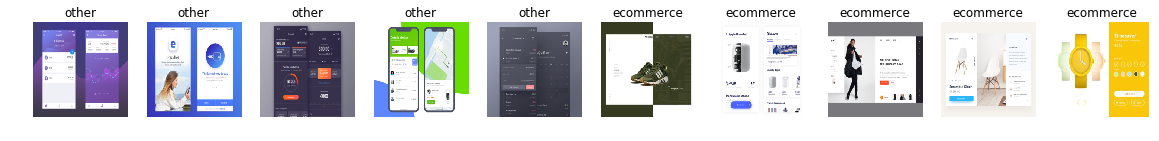

In [8]:
## Plot the result.
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
for i, j in enumerate(np.sort(np.random.randint(0, test_data.shape[0], size=10))): 
    fullname = os.path.join("test_img", test_names[i])
    im = Image.open(fullname)
    class_name = predicted_labels[j]
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(class_name, loc='center')
    ax[i].imshow(im)